In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from aggregate import *
from utils import *

# **We predict yearly carbon emission per surface, for 2030:**

We will train our model this time on `final_data.csv` entirely. We are looking for 2030 predictions.

In [131]:
# Read preprocessed data
data_raw = pd.read_csv('final_data.csv', index_col='Unnamed: 0', parse_dates=['date_etablissement_dpe'])

In [132]:

# Split data according to category
data = split(data_raw)

Let's take a look at the unique dates to have an idea of the size of our time series.

In [133]:
for key in data.keys():
    print(f'Column: {key}'.ljust(19, ' ') + '--->' + f'Size = {data[key].date_etablissement_dpe.unique().shape[0]}'.rjust(12, ' '))

Column: admin      ---> Size = 4252
Column: centre_com ---> Size = 3418
Column: occup_cont ---> Size = 3246
Column: autre      ---> Size = 4043


**Aggregating columns with respect to the date column**

In [134]:
ts ={key: {freq: extract_vect_ts(df, freq) for freq in ['D', 'W', 'M']} for key, df in data.items()}

c:\Users\chiha\Studies\Centralesupelec\2A\Scolarité\Projet BNP\github\commercial-real-estate\utils.py:69: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = ts.resample(freq).mean().resample(freq).interpolate(method='linear')
c:\Users\chiha\Studies\Centralesupelec\2A\Scolarité\Projet BNP\github\commercial-real-estate\utils.py:69: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = ts.resample(freq).mean().resample(freq).interpolate(method='linear')
c:\Users\chiha\Studies\Centralesupelec\2A\Scolarité\Projet BNP\github\commercial-real-estate\utils.py:69: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = ts.resample(freq).mean().resample(freq).interpolate(method='linear')
c:\Users\chiha\Studies\Centralesupelec\2A\Scolarité\Projet BNP\github\commercial-real-estate\utils.py:69: FutureWarning: 'M' is deprecated and will be remove

In [135]:
ts['admin']['W']  # ts['sector']['frequency']

,annee_construction,surface_utile,coord_x,coord_y,emission_ges
date_etablissement_dpe,,,,,
2013-01-13,1974.000000,100.000000,661276.385727,6.863710e+06,27.130000
2013-01-20,1974.000000,100.000000,642131.351753,6.841609e+06,27.515000
2013-01-27,1974.000000,100.000000,622986.317779,6.819508e+06,27.900000
2013-02-03,1974.000000,100.000000,603841.283805,6.797406e+06,28.285000
2013-02-10,1974.000000,100.000000,584696.249830,6.775305e+06,28.670000
...,...,...,...,...,...
2024-12-08,1966.110170,234.024132,675958.215238,6.663887e+06,11.360938
2024-12-15,1966.023341,177.840398,661427.597506,6.661860e+06,8.770826
2024-12-22,1965.049847,173.369254,651383.875067,6.653682e+06,9.580173


_Remark:_ For the resampling step, only 156 rows out of our 4375 rows were interpolated, the remaining rows were already present in the dataset.

We prepare the data for Prophet model

In [136]:
## Prophet nomenclature
def Prophetnom(df):
    df.reset_index(inplace=True)
    df.rename(columns={'date_etablissement_dpe':'ds','emission_ges':'y'}, inplace=True)

Prophetnom(ts['admin']['W'])
Prophetnom(ts['centre_com']['W'])
Prophetnom(ts['autre']['W'])
Prophetnom(ts['occup_cont']['W'])


Here, we create the model and we fit it

In [137]:
# Model for each category

model_admin=Prophet()
model_centre_com=Prophet()
model_autre=Prophet()
model_occup_cont=Prophet()


# Fitting 

model_admin.fit(ts['admin']['W'])
model_centre_com.fit(ts['centre_com']['W'])
model_autre.fit(ts['autre']['W'])
model_occup_cont.fit(ts['occup_cont']['W'])

18:55:50 - cmdstanpy - INFO - Chain [1] start processing
18:55:50 - cmdstanpy - INFO - Chain [1] done processing
18:55:50 - cmdstanpy - INFO - Chain [1] start processing
18:55:50 - cmdstanpy - INFO - Chain [1] done processing
18:55:50 - cmdstanpy - INFO - Chain [1] start processing
18:55:51 - cmdstanpy - INFO - Chain [1] done processing
18:55:51 - cmdstanpy - INFO - Chain [1] start processing
18:55:51 - cmdstanpy - INFO - Chain [1] done processing


In [138]:
# The forecast
# With the following exact periods, the last line of our predictions correspond to the first week of 2030
future_admin = model_admin.make_future_dataframe(periods=52 * 5+1, freq='W')
future_centre_com = model_centre_com.make_future_dataframe(periods=52 * 5+1, freq='W')
future_autre = model_autre.make_future_dataframe(periods=52 * 5+1, freq='W')
future_occup_cont = model_occup_cont.make_future_dataframe(periods=52 * 5+1, freq='W')

forecast_admin = model_admin.predict(future_admin)
forecast_centre_com = model_centre_com.predict(future_centre_com)
forecast_autre = model_autre.predict(future_autre)
forecast_occup_cont = model_occup_cont.predict(future_occup_cont)

# **We use `markowitz_dataset.csv` to build a credit rate table by building category.:**

In [139]:
data_rate = pd.read_csv('data/markowitz_dataset.csv', encoding='latin1', usecols=['asset_type_cre', 'taux_credit'])

In [140]:
data_rate=pd.DataFrame(data_rate.groupby('asset_type_cre').mean())

In [141]:
data_rate.reset_index(inplace=True)

In [142]:
def asset_type_format_fct(x):
    return asset_type_format[x]


asset_type_format={"Bâtiment à usage principale de bureau, d'administration ou d'enseignement":"admin",
                   "Bâtiment à occupation continue (par exemple: hopitaux, hôtels, internats, maisons de retraite, etc)":"occup_cont",
                   "Autres cas (par exemple: théâtres, salles de sport, restauration, commerces individuels, etc)":"autre",
                   "Centre commercial":"centre_com"}

In [143]:
data_rate.asset_type_cre=data_rate.asset_type_cre.apply(asset_type_format_fct)

In [144]:
data_rate

,asset_type_cre,taux_credit
0,autre,0.032059
1,occup_cont,0.022727
2,admin,0.020678
3,centre_com,0.023780


In [145]:
forecast_admin['yhat'].iloc[-1]

np.float64(11.617772073894313)

In [146]:
data_emission_2030=pd.DataFrame({'asset_type_cre':['admin','autre','centre_com','occup_cont'],
                                 'emission_ges':[forecast_admin['yhat'].iloc[-1],forecast_autre['yhat'].iloc[-1],forecast_centre_com['yhat'].iloc[-1],forecast_occup_cont['yhat'].iloc[-1]]})


In [147]:
data_emission_2030

,asset_type_cre,emission_ges
0,admin,11.617772
1,autre,15.692469
2,centre_com,9.778857
3,occup_cont,11.140794


In [148]:
data_2030=data_rate.set_index('asset_type_cre', drop=True).join(data_emission_2030.set_index('asset_type_cre',drop=True))

In [149]:
data_2030

,taux_credit,emission_ges
asset_type_cre,,
autre,0.032059,15.692469
occup_cont,0.022727,11.140794
admin,0.020678,11.617772
centre_com,0.023780,9.778857


As for `optim.py`, we solve the optimisation problem:

[15.69246896  0.03205882]
[15.6924683   0.03205882]


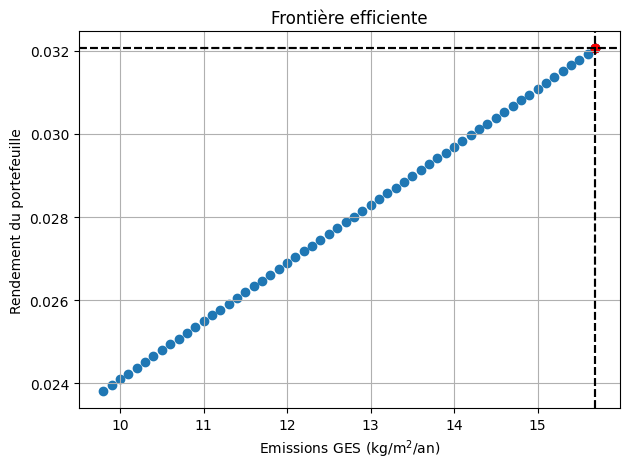

[array([3.57527308e-03, 3.99297841e-08, 2.33272979e-08, 9.96424664e-01]), array([2.04852743e-02, 6.77298700e-08, 7.23994244e-08, 9.79514586e-01]), array([3.73953863e-02, 2.23501712e-07, 1.29243562e-07, 9.62604261e-01]), array([5.43056381e-02, 1.02111510e-07, 6.02444143e-08, 9.45694200e-01]), array([7.12158295e-02, 4.44278005e-08, 2.39912743e-08, 9.28784102e-01]), array([8.81259827e-02, 2.78868010e-08, 1.17847631e-08, 9.11873978e-01]), array([1.05036126e-01, 1.70219605e-08, 1.32737653e-09, 8.94963856e-01]), array([1.21946258e-01, 2.22740397e-08, 2.21696226e-09, 8.78053718e-01]), array([1.38856398e-01, 1.58903649e-08, 2.12333370e-09, 8.61143584e-01]), array([1.55766543e-01, 1.69184235e-08, 4.71496302e-09, 8.44233435e-01]), array([1.72676684e-01, 1.31758285e-08, 2.77724178e-09, 8.27323300e-01]), array([1.89586627e-01, 1.58361560e-07, 1.56870113e-07, 8.10413058e-01]), array([2.06496811e-01, 1.55463644e-07, 1.49329569e-07, 7.93502885e-01]), array([2.23406972e-01, 1.53910083e-07, 1.39789087e

In [152]:
# Inputs
r = np.array(data_2030.taux_credit)
e = np.array(data_2030.emission_ges)
n = len(r)

# Visualisation
r_opt = []
e_opt = []
w_opt = []

for t in np.arange(9.8, 16, 0.1):
    w = cp.Variable(n, nonneg=True)
    objective = cp.Minimize(- w@r)
    contraints = [
        cp.sum(w) == 1, 
        w@e <= t
    ]


    # Résolution
    prob = cp.Problem(objective, contraints)
    prob.solve()
    
    w = w.value
    
    w_opt.append(w)
    r_opt.append(w@r)
    e_opt.append(w@e)

def singularities(x, y, tol):
    singu = []
    for i in range(1, len(y)-1):
        if abs(((y[i+1] - y[i])/(x[i+1] - x[i])) - ((y[i] - y[i-1])/(x[i] - x[i-1])))>tol:
            singu.append([x[i], y[i]])
    return singu


singu = np.array(singularities(e_opt, r_opt, tol=1e-6))
plt.scatter(x=e_opt, y=r_opt)
plt.scatter(x=singu[:, 0], y=singu[:, 1], color='red')
for s in singu:
    print(s)
    plt.axvline(x=s[0], linestyle='--', color='black')
    plt.axhline(y=s[1], linestyle='--', color='black')

plt.grid(True)
plt.ylabel("Rendement du portefeuille")
plt.xlabel("Emissions GES (kg/m$^2$/an)")
plt.title("Frontière efficiente")
plt.tight_layout()
plt.show()
print(w_opt)